In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from numpy import array
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

from numpy.random import seed

In [3]:
seed(1)
tf.random.set_seed(1)

n_timestamp = 40 # 时间步长(用前40天预测下一天)
n_epochs = 20 # 训练轮数
model_type = 1 
# ====================================
#      选择模型：
#            1: 单层 LSTM
#            2: 多层 LSTM
#            3: 双向 LSTM
# ====================================

In [7]:
data = pd.read_csv('SH600519.csv')

data

,Unnamed: 0,date,open,close,high,low,volume,code
0,74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
1,75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
2,76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
3,77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
4,78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519
...,...,...,...,...,...,...,...,...
2421,2495,2020-04-20,1221.000,1227.300,1231.500,1216.800,24239.00,600519
2422,2496,2020-04-21,1221.020,1200.000,1223.990,1193.000,29224.00,600519
2423,2497,2020-04-22,1206.000,1244.500,1249.500,1202.220,44035.00,600519
2424,2498,2020-04-23,1250.000,1252.260,1265.680,1247.770,26899.00,600519


In [13]:
training_set = data.iloc[0:2426-300, 2:3].values
test_set = data.iloc[2426-300:, 2:3].values

In [15]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(test_set)

In [17]:
def data_split(sequence, n_timestamp): # 
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp # 当前序列结束位置

        if end_ix > len(sequence) - 1: # 检查是否超出序列长度
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# 生成训练集和测试集
X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)

# 调整维度: [样本数，时间步长，特征数]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (2085, 40, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
if model_type == 1:
    model = Sequential()
    model.add(LSTM(units=50, activation='relu',
                  input_shape=(X_train.shape[1], 1))) # 按时间顺序处理 input_shape=(time_stamp, num_feature)
    model.add(Dense(units=1))

if model_type == 2:
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True,
                  input_shape=(X_train.shape[1], 1)))
    model.add(LTSM(units=50, activation='relu'))
    model.add(Dense(1))

if model_type == 3:
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'),
                           input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')

In [23]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)

model.summary()

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0413 - val_loss: 0.0235
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 1.1334
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7881e-04 - val_loss: 0.1736
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1465e-04 - val_loss: 0.0643
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2031e-04 - val_loss: 0.0363
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7897e-04 - val_loss: 0.0210
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5454e-04 - val_loss: 0.0133
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4140e-04 - val_loss: 0.0088
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3107e-04 - val_loss: 0.0061
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2309e-04 - val_loss: 0.0042
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1639e-04 - val_loss: 0.0031
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

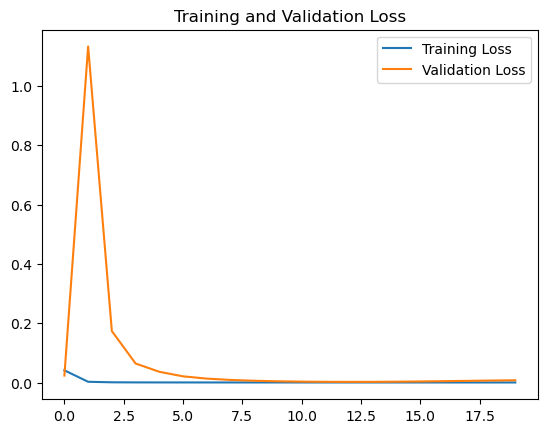

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


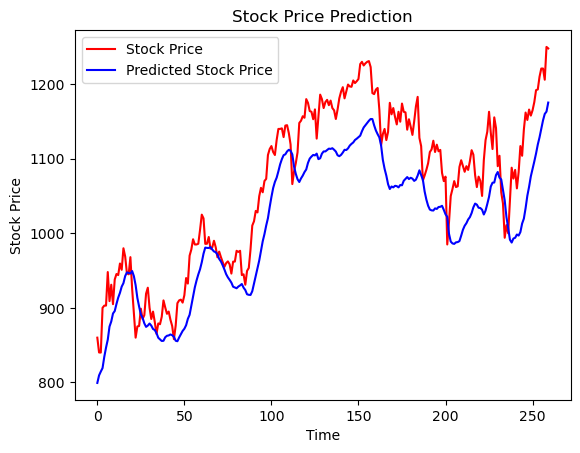

In [27]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(y_test)

plt.plot(real_stock_price, color='red', label='Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [31]:
MSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)
RMSE = metrics.mean_squared_error(predicted_stock_price, real_stock_price)**0.5
MAE = metrics.mean_absolute_error(predicted_stock_price, real_stock_price)
R2 = metrics.r2_score(predicted_stock_price, real_stock_price)

print('均方误差: %.5f, 均方根误差: %.5f, 平均绝对误差: %.5f, R2: %.5f' % (MSE, RMSE, MAE, R2))

均方误差: 3892.25995, 均方根误差: 62.38798, 平均绝对误差: 54.80301, R2: 0.52504
